## K-Means

Given a set of datapoints ${x_1, ..., x_n}$ and a positive number $k$, find the clusters $C_1, ..., C_k$ that minimize

\begin{equation}
J = \sum_{i=1}^n \, \sum_{j=1}^k \, z_{ij} \, || x_i - \mu_j ||_2
\end{equation}

where:  
- $z_{ij} \in \{0,1\}$ defines whether of not datapoint $x_i$ belongs to cluster $C_j$
- $\mu_j$ denotes the cluster center of cluster $C_j$
- $|| \, ||_2$ denotes the Euclidean distance


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances

from utils import plot_decision_boundaries


In [2]:
data = pd.read_csv('data.csv',header=None).values
data.shape

(150, 2)

In [3]:
def visualize_data(X):
    plt.scatter(X[:,0],X[:,1],c='b',s=5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
plt.figure(figsize=(4,4))
visualize_data(data)
plt.show()

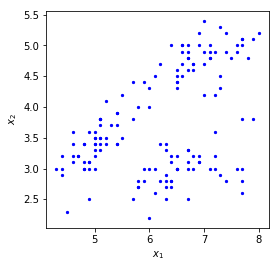

In [4]:
plt.figure(figsize=(4,4))
visualize_data(data)
plt.show()

In [5]:
def row_norm(X, squared=True):
    #Row-wise (squared) Euclidean norm of X.
    #Equivalent to np.sqrt((X * X).sum(axis=1))
    norms = np.einsum('ij,ij->i', X, X)
    if not squared:
        np.sqrt(norms, norms)
    return norms

def _kplus_init(X, n_clusters, random_state, x_squared_norms):
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)
    
    n_local_trials = 2 + int(np.log(n_clusters))
    
    center_id = random_state.randint(n_samples)
    
    closest_dist_sq = euclidean_distances(centers[0, np.newaxis], 
                                          X, 
                                          Y_norm_squared=x_squared_norms,
                                          squared=True)
    current_pot = closest_dist_sq.sum()
    for c in range(1, n_clusters):
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(np.cumsum(closest_dist_sq),
                                        rand_vals)

        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        centers[c] = X[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    return centers    

def _random_init(X, n_clusters, random_state):
    seeds = random_state.permutation(X.shape[0])[:n_clusters]
    centers = X[seeds]
    return centers
    
def _init_centroids(X, n_clusters, random_state,x_squared_norms=None, init='kplus'): 
    if init == 'random':
        centers = _random_init(X, n_clusters, random_state)
    else:
        centers = _kplus_init(X, n_clusters, random_state, x_squared_norms)
    return centers
  

def _assign_labels(X, centers):
    dist = pairwise_distances(X, centers,metric='euclidean')
    assignments = np.argmin(dist,axis=1)
    return assignments

def _get_centers(X, assignments):
    new_centers = []
    for i in np.unique(assignments):
        new_centers.append(X[assignments == i].mean(axis=0))
    return np.array(new_centers)

def _kmeans_lloyd(X, n_clusters, random_state, init, max_iter = 240):
    x_squared_norms = row_norm(X)
    centers = _init_centroids(X, n_clusters, random_state, x_squared_norms,init=init)
    distances = np.zeros(shape=(X.shape[0],), dtype=X.dtype)

    for i in range(max_iter):
        centers_old = centers.copy()
        # E-step of EM
        assignments = _assign_labels(X, centers)
        # M-step of EM
        centers = _get_centers(X, assignments)
    return centers, assignments

In [6]:
class KMeans():
    def __init__(self,n_clusters:int, random_seed:int = 65):
        self.n_clusters = n_clusters
        self.random_state = np.random.RandomState(random_seed)      
        
    def fit(self,X):
        #X_mean = X.mean(axis=0)
        #X -= X_mean
        self.cluster_centers_, self.labels_ = _kmeans_lloyd(X=X,
                                                            n_clusters = self.n_clusters,
                                                            random_state = self.random_state,
                                                            init ='random')

        return self
    
    def fit_predict(self,X):
        return self.fit(X).labels_
    
    def predict(self, X):
        #X_mean = X.mean(axis=0)
        #X -= X_mean
        if self.labels_ is not None:
            return _assign_labels(X, self.cluster_centers_)
        
    

In [7]:
kmeans = KMeans(n_clusters=3, random_seed=14)
y_pred = kmeans.fit_predict(data)
y_pred is kmeans.labels_

True

In [8]:
kmeans.cluster_centers_

array([[6.98823529, 4.74705882],
       [5.02307692, 3.42115385],
       [6.5787234 , 2.94893617]])

In [9]:
a = np.arange(10)
np.sort(a[:3])

array([0, 1, 2])

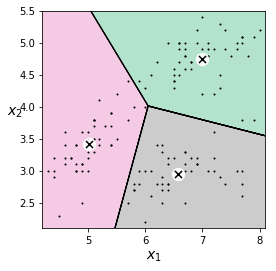

In [10]:
plt.figure(figsize=(4, 4))
plot_decision_boundaries(kmeans, data)

plt.show()

In [11]:
'''
def _labels_inertia(X, x_squared_norms, centers,
                    distances=None):
    
    n_samples = X.shape[0]
    # set the default value of centers to -1 to be able to detect any anomaly
    # easily
    labels = np.full(n_samples, -1, np.int32)
    if distances is None:
        distances = np.zeros(shape=(0,), dtype=X.dtype)

    inertia = _assign_labels_array(
        X, x_squared_norms, centers, labels,
        distances=distances)
    return labels, inertia
'''

'\ndef _labels_inertia(X, x_squared_norms, centers,\n                    distances=None):\n    \n    n_samples = X.shape[0]\n    # set the default value of centers to -1 to be able to detect any anomaly\n    # easily\n    labels = np.full(n_samples, -1, np.int32)\n    if distances is None:\n        distances = np.zeros(shape=(0,), dtype=X.dtype)\n\n    inertia = _assign_labels_array(\n        X, x_squared_norms, centers, labels,\n        distances=distances)\n    return labels, inertia\n'

In [12]:
def _compute_distances(points):
    n = points.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i,j] = np.linalg.norm(points[i,:] - points[j,:])
    return distances
test1 = _compute_distances(data)
X_copy = data.copy()
test2 = pairwise_distances(data, data)
# test1 == test2 with tolerance